In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%cd C:\Users\camer\.ipynb_checkpoints
df=pd.read_csv("coin_Bitcoin.csv", parse_dates=['Date'])
df

C:\Users\camer\.ipynb_checkpoints


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2857,2858,Bitcoin,BTC,2021-02-23 23:59:59,54204.929756,45290.590268,54204.929756,48824.426869,1.061025e+11,9.099259e+11
2858,2859,Bitcoin,BTC,2021-02-24 23:59:59,51290.136695,47213.498162,48835.087661,49705.333316,6.369552e+10,9.263931e+11
2859,2860,Bitcoin,BTC,2021-02-25 23:59:59,51948.966982,47093.853019,49709.082425,47093.853019,5.450657e+10,8.777661e+11
2860,2861,Bitcoin,BTC,2021-02-26 23:59:59,48370.785260,44454.842114,47180.464054,46339.760083,3.509679e+11,8.637523e+11


In [2]:
# Performing Dickey-Fuller test to see if data is stationary data.
df1 = df[['Date','Close']]
df_ts = df1.set_index('Date')
df_ts.sort_index(inplace=True)
def test_stationarity(timeseries):
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================================")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
ts = df_ts['Close']
test_stationarity(ts)
# Closing data is non-stationary based on the Dickey-Fuller test. Therefore, summary statistics such as mean and variance do change
# with time.

Results of Dickey-Fuller Test:
Test Statistic                    4.617884
p-value                           1.000000
#lags Used                       28.000000
Number of Observations Used    2833.000000
Critical Value (1%)              -3.432660
Critical Value (5%)              -2.862561
Critical Value (10%)             -2.567313
dtype: float64


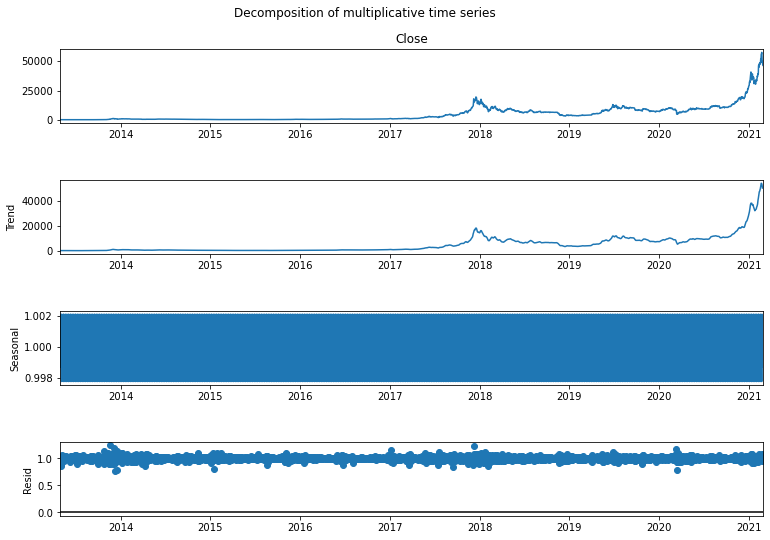

In [3]:
# Check for seasonality. 
rolmean = ts.rolling(window=12).mean()
rolvar = ts.rolling(window=12).std()
decomposition = sm.tsa.seasonal_decompose(ts, model='multiplicative')
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()
# The data is too complicated from a daily approach for seasonality. 

In [4]:
df_ts_m = df_ts.resample('M').mean()
tsm = df_ts_m['Close']
test_stationarity(tsm)
# Data is still non-stationary when the mean is used.

Results of Dickey-Fuller Test:
Test Statistic                  2.246874
p-value                         0.998919
#lags Used                      1.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


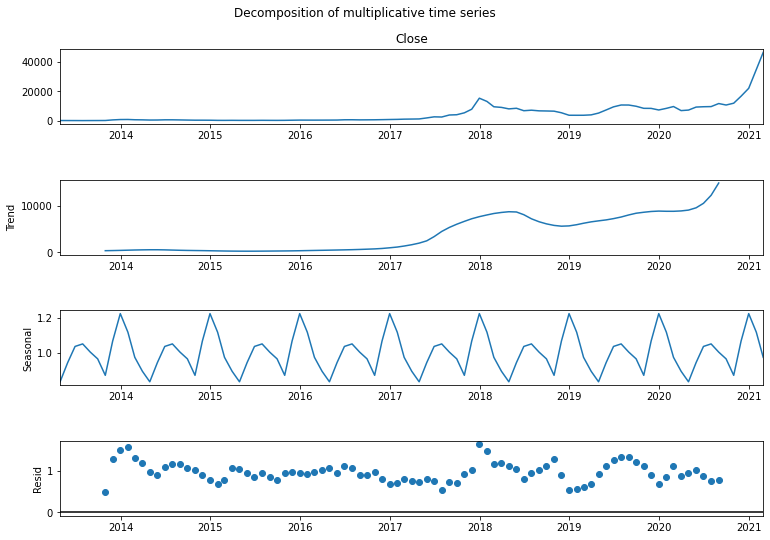

In [5]:
# Check for seasonality of mean close.
decomposition = sm.tsa.seasonal_decompose(tsm, model='multiplicative')
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()
# As it shows, there is some seasonality.

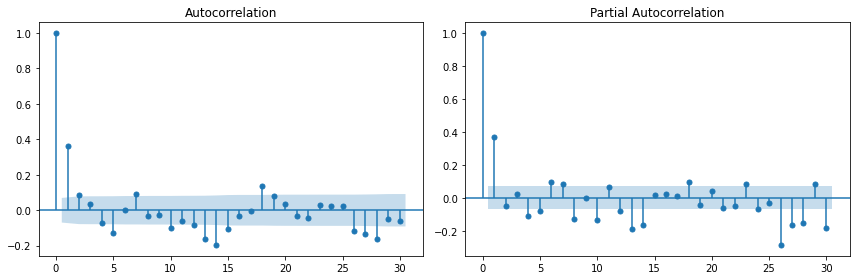

In [6]:
# Autocorrelation plot for "stationary" data. 
tsmlog = np.log10(tsm)
tsmlog.dropna(inplace=True)
tsmlogdiff = tsmlog.diff(periods=1)
tsmlogdiff.dropna(inplace=True)
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(tsmlogdiff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(tsmlogdiff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2861
Model:                 ARIMA(5, 1, 9)   Log Likelihood              -21157.115
Method:                       css-mle   S.D. of innovations            393.767
Date:                Sun, 23 May 2021   AIC                          42346.231
Time:                        19:46:14   BIC                          42441.574
Sample:                    04-30-2013   HQIC                         42380.608
                         - 02-27-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.9427     10.919      1.368      0.171      -6.459      36.344
ar.L1.D.Close     0.1380      0.059      2.334      0.020       0.022       0.254
ar.L2.D.Close     1.1092      0.033     

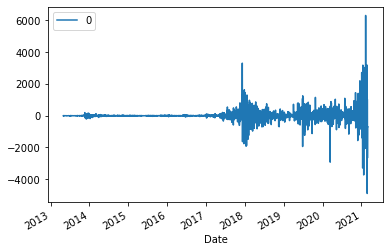

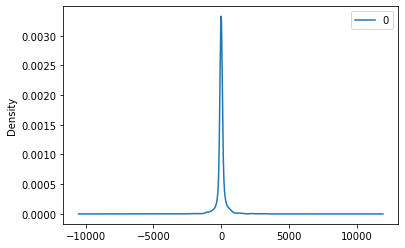

                 0
count  2861.000000
mean     -0.008222
std     393.836420
min   -4910.684007
25%     -31.406174
50%      -8.910744
75%      25.055122
max    6307.284034


In [7]:
# Bulid the ARIMA model. ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that 
# ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, 
# so that equation can be used to forecast future values.
# An ARIMA model is characterized by 3 terms: p, d, q- the imput below "Model:ARIMA(5, 1, 9)"
# where,
# p is the order of the AR term
# d is the number of differencing required to make the time series stationary
# q is the order of the MA term

# First 5 lags is signifcant p=5. Since lag 1, 2, 3, 4 are near or out confidence interval, and lag 6 is in the blue area.

# First order differencing make the ts stationary, d = 1. An autocorrelation of lag 1 will measure the relationship between 
# the today’s value (Yt) and yesterday’s value (Yt-1). 

# q = 9 since 9 are out of the blue in partial autocorrelation.

# The plot above helps to choose these parameters.
crypto_data = {}
crypto_data['bitcoin'] = pd.read_csv("coin_Bitcoin.csv", parse_dates=['Date'])
df_bitcoin = pd.DataFrame(crypto_data['bitcoin'])
df_bitcoin = df_bitcoin[['Date','Close']]
df_bitcoin.set_index('Date', inplace = True)
# fit model
model = ARIMA(df_bitcoin, order=(5,1,9))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())
# This link shows general form of ARIMA model: https://ademos.people.uic.edu/Chapter23.html

In [8]:
def parser(x):
 return datetime.strptime('190'+x, '%Y-%m')
X = df_bitcoin.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
# evaluate forecasts
# plot forecasts against actual outcomes

In [9]:
predictions = list()
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,9))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

predicted=6143.047783, expected=6404.000000
predicted=6339.685737, expected=6385.819824
predicted=6311.505549, expected=6614.180176
predicted=6592.654504, expected=6529.589844
predicted=6578.918535, expected=6597.549805
predicted=6710.680560, expected=6639.140137
predicted=6709.220976, expected=6673.500000
predicted=6807.583350, expected=6856.930176
predicted=6954.379959, expected=6773.879883
predicted=6797.894533, expected=6741.750000
predicted=6810.119670, expected=6329.950195
predicted=6260.841070, expected=6394.709961
predicted=6408.632868, expected=6228.810059
predicted=6101.674901, expected=6238.049805
predicted=6160.671797, expected=6276.120117
predicted=6172.513605, expected=6359.640137
predicted=6312.064635, expected=6741.750000
predicted=6755.816946, expected=7321.040039
predicted=7284.649867, expected=7370.779785
predicted=7415.894160, expected=7466.859863
predicted=7506.032049, expected=7354.129883
predicted=7460.588761, expected=7419.290039
predicted=7624.326161, expected=

predicted=3829.162641, expected=3836.741319
predicted=3717.333563, expected=3857.717619
predicted=3828.794618, expected=3845.194460
predicted=3856.949275, expected=4076.632685
predicted=4175.605297, expected=4025.248287
predicted=4089.417604, expected=4030.847999
predicted=4147.974384, expected=4035.296369
predicted=4141.396533, expected=3678.924681
predicted=3725.014784, expected=3687.365482
predicted=3723.526840, expected=3661.300990
predicted=3592.574354, expected=3552.953068
predicted=3508.328884, expected=3706.052220
predicted=3563.004907, expected=3630.675225
predicted=3543.399746, expected=3655.006886
predicted=3607.375792, expected=3678.563976
predicted=3567.510354, expected=3657.839435
predicted=3702.920508, expected=3728.568365
predicted=3708.911834, expected=3601.013592
predicted=3666.830142, expected=3576.032439
predicted=3683.162737, expected=3604.577052
predicted=3673.655411, expected=3585.123066
predicted=3704.562735, expected=3600.865501
predicted=3587.217751, expected=

KeyboardInterrupt: 

In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

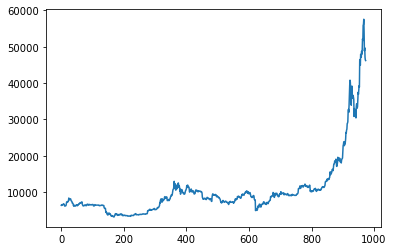

In [10]:
plt.plot(test)

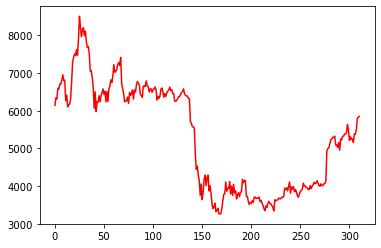

In [11]:
plt.plot(predictions, color='red')